In [31]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import logging
import os

# Set up logging
logging.basicConfig(filename="scraping.log", level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Base URL for British Airways reviews on Skytrax
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

# Output directory
output_dir = os.getenv("OUTPUT_DIR", r"C:\Users\kaurs\Downloads\scrapes")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "skytrax_ba_reviews.csv")

# User agents for rotation
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
]

# Scrape reviews
reviews_list = []
headers = {"User-Agent": random.choice(user_agents)}
numpage = 50  # Number of pages to scrape

for page in range(1, numpage + 1):
    page_url = f"{base_url}/page/{page}/"
    logging.info(f"Scraping Page {page}...")
    headers["User-Agent"] = random.choice(user_agents)
    response = requests.get(page_url, headers=headers)

    if response.status_code != 200:
        logging.warning(f"Failed to retrieve page {page}. Status Code: {response.status_code}")
        continue

    soup = BeautifulSoup(response.text, "html.parser")
    reviews = soup.find_all("article", class_="comp_media-review-rated")

    if not reviews:
        logging.warning(f"No reviews found on page {page}. The class name may have changed.")
        continue

    for review in reviews:
        try:
            # Extract review text
            review_text_div = review.find("div", class_="text_content")
            review_text = review_text_div.text.strip() if review_text_div else "No review text"

            # Extract table data
            table_data = {}
            rating_table = review.find("table", class_="review-ratings")
            if rating_table:
                for row in rating_table.find_all("tr"):
                    header = row.find("td", class_="review-rating-header")
                    value = row.find("td", class_="review-value")
                    if header and value:
                        header_text = header.text.strip()
                        value_text = value.text.strip()
                        table_data[header_text] = value_text

                    # Handle star ratings
                    stars = row.find("td", class_="review-rating-stars")
                    if stars:
                        header_text = row.find("td", class_="review-rating-header").text.strip()
                        star_count = len(stars.find_all("span", class_="star fill"))
                        table_data[header_text] = star_count

            # Append review data to list
            reviews_list.append({
                "Review Text": review_text,
                **table_data  # Unpack table data dictionary
            })

        except Exception as e:
            logging.error(f"Skipping a review due to error: {e}")

    # Random sleep to avoid overloading the server
    time.sleep(random.uniform(3, 7))

# Save data to CSV
if reviews_list:
    df = pd.DataFrame(reviews_list)
    df.to_csv(output_file, index=False, encoding="utf-8")
    logging.info(f"Scraping completed. Data saved to: {output_file}")
else:
    logging.warning("No reviews were scraped. The CSV file is empty.")

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
import re


In [33]:
df = pd.read_csv("C:/Users/kaurs/Downloads/data/skytrax_ba_reviews.csv")
print(df.head())

                                         Review Text Aircraft  \
0  Not Verified |  Very good flight following an ...     A320   
1  Not Verified |  An hour's delay due to late ar...     A319   
2  ✅ Trip Verified |   I booked through BA becaus...      NaN   
3  ✅ Trip Verified |   British airways lost bags ...      NaN   
4  ✅ Trip Verified | The check in process and rew...     A320   

  Type Of Traveller        Seat Type                          Route  \
0      Solo Leisure   Business Class      London Heathrow to Zurich   
1    Family Leisure    Economy Class               London to Lisbon   
2      Solo Leisure    Economy Class      Manchester to Isle of Man   
3    Family Leisure  Premium Economy  Houston to cologne via London   
4          Business    Economy Class                London to Basel   

      Date Flown  Seat Comfort  Cabin Staff Service  Food & Beverages  \
0   January 2025           3.0                  4.0               4.0   
1   January 2025           3.0      

In [34]:
df["Review Text"] = df["Review Text"].str.replace(r"^(Not Varified| Trip Varified) \| ","", regex=True)

In [36]:
print(df.isnull().sum())

Review Text                 0
Aircraft                  244
Type Of Traveller           1
Seat Type                   0
Route                       2
Date Flown                  0
Seat Comfort               30
Cabin Staff Service        38
Food & Beverages          109
Ground Service             14
Value For Money             0
Recommended                 0
Inflight Entertainment    233
Wifi & Connectivity       315
dtype: int64


In [38]:
df["Aircraft"] = df["Aircraft"].fillna("Unknown")
df["Type Of Traveller"]= df["Type Of Traveller"].fillna("Unknown")
df["Route"] = df["Route"].fillna("Unknown")  

numeric_columns = ["Wifi & Connectivity","Inflight Entertainment","Ground Service","Food & Beverages","Cabin Staff Service","Seat Comfort"]
df[numeric_columns] = df[numeric_columns].fillna(0)

In [39]:
print(df.isnull().sum())

Review Text               0
Aircraft                  0
Type Of Traveller         0
Seat Type                 0
Route                     0
Date Flown                0
Seat Comfort              0
Cabin Staff Service       0
Food & Beverages          0
Ground Service            0
Value For Money           0
Recommended               0
Inflight Entertainment    0
Wifi & Connectivity       0
dtype: int64


In [43]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()
df["Review Text"] = df["Review Text"].apply(clean_text)
df["Type Of Traveller"] = df["Type Of Traveller"].apply(clean_text)
df["Seat Type"] = df["Seat Type"].apply(clean_text)
df["Route"] = df["Route"].apply(clean_text)

In [44]:
df["Date Flown"]= pd.to_datetime(df["Date Flown"], format = "%B %Y", errors ="coerce")

In [48]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kaurs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [49]:

from nltk.sentiment import SentimentIntensityAnalyzer

sia =  SentimentIntensityAnalyzer()

df["Sentiment"] = df["Review Text"].apply(lambda x: sia.polarity_scores(x)["compound"])

df["Sentiment Category"] = df["Sentiment"].apply(
    lambda x:"Positive" if x > 0 else ("Negative" if x<0 else "Netural")
)

In [50]:
df["Recommend Binary"] = df["Recommended"].apply(lambda x: 1 if x == "yes" else 0)

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric])

In [53]:
df["Word Count"] = df["Review Text"].apply(lambda x: len(x.split()))

In [54]:
df.to_csv("C:/Users/kaurs/Downloads/data/Cleaned_data_skytrax.csv", index = False)

In [57]:
#EDA
print(df["Sentiment Category"].value_counts())
print(df["Recommended"].value_counts())
print(df[numeric_columns].describe())

Sentiment Category
Negative    289
Positive    207
Netural       4
Name: count, dtype: int64
Recommended
no     376
yes    124
Name: count, dtype: int64
       Wifi & Connectivity  Inflight Entertainment  Ground Service  \
count           500.000000              500.000000      500.000000   
mean              0.142800                0.272800        0.435200   
std               0.242912                0.326241        0.297014   
min               0.000000                0.000000        0.000000   
25%               0.000000                0.000000        0.200000   
50%               0.000000                0.200000        0.200000   
75%               0.200000                0.600000        0.600000   
max               1.000000                1.000000        1.000000   

       Food & Beverages  Cabin Staff Service  Seat Comfort  
count        500.000000           500.000000    500.000000  
mean           0.378400             0.537600      0.475200  
std            0.318333          

In [62]:

print(df["Review Text"].head())


0    not verified very good flight following an equ...
1    not verified an hours delay due to late arriva...
2    trip verified i booked through ba because loga...
3    trip verified british airways lost bags in lhr...
4    trip verified the check in process and rewardl...
Name: Review Text, dtype: object


In [63]:
print(df["Review Text"].isnull().sum())

0


In [65]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaurs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [66]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
all_reviews = " ".join([word for word in all_reviews.split() if word.lower() not in stop_words])

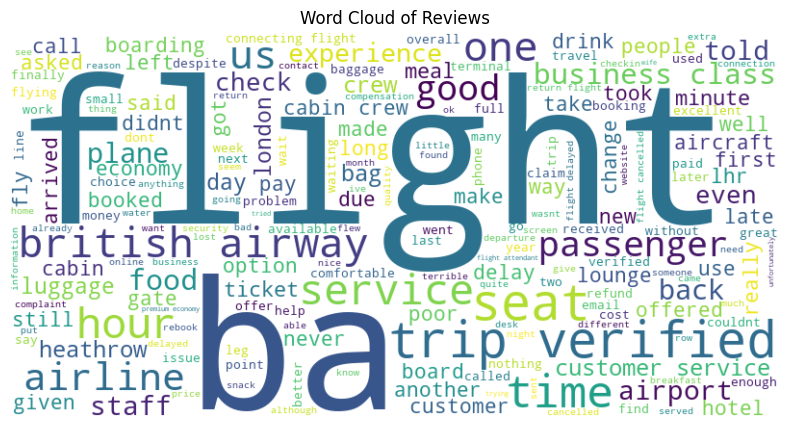

In [67]:
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show()


In [68]:
print("Total words in all reviews:", len(all_reviews.split()))


Total words in all reviews: 43765


C:\Users\kaurs\AppData\Local\Temp\ipykernel_5924\463519078.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment Category" , data = df, palette = "coolwarm")


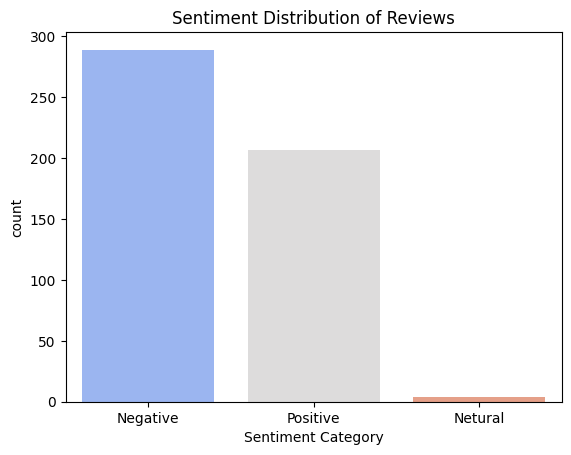

In [69]:
sns.countplot(x="Sentiment Category" , data = df, palette = "coolwarm")
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment Category")
plt.ylabel("count")
plt.show()

C:\Users\kaurs\AppData\Local\Temp\ipykernel_5924\93007612.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sentiment Category", y="Seat Comfort", data=df, palette="viridis")


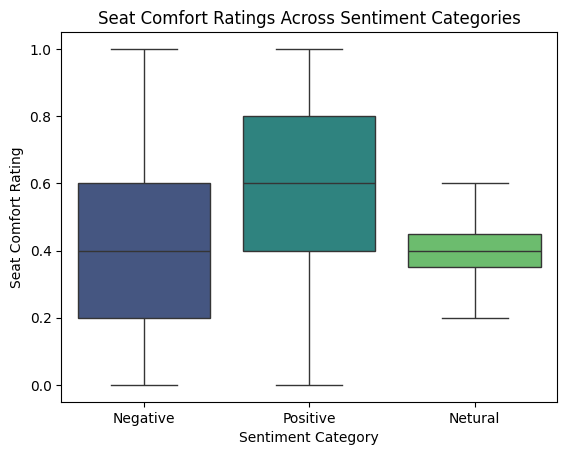

In [70]:
sns.boxplot(x="Sentiment Category", y="Seat Comfort", data=df, palette="viridis")
plt.title("Seat Comfort Ratings Across Sentiment Categories")
plt.xlabel("Sentiment Category")
plt.ylabel("Seat Comfort Rating")
plt.show()


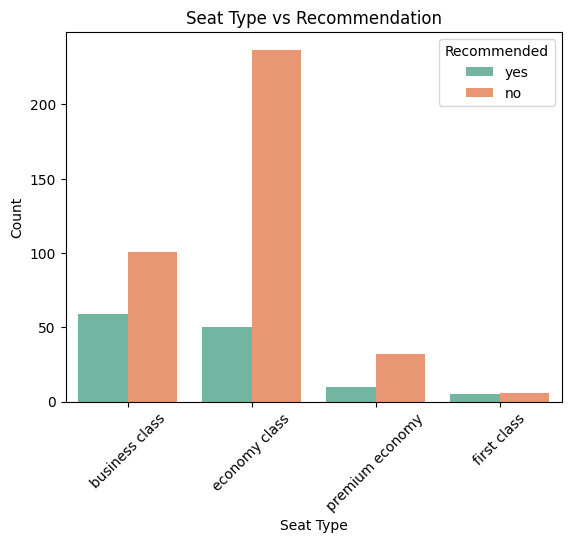

In [71]:
sns.countplot(x="Seat Type", hue="Recommended", data=df, palette="Set2")
plt.title("Seat Type vs Recommendation")
plt.xlabel("Seat Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


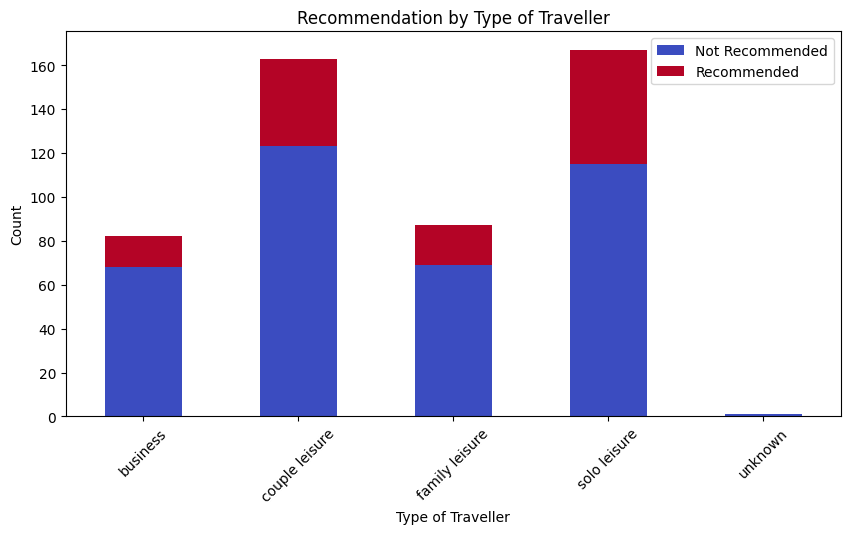

In [72]:
traveller_recommend = df.groupby(["Type Of Traveller", "Recommended"]).size().unstack()
traveller_recommend.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(10,5))
plt.title("Recommendation by Type of Traveller")
plt.xlabel("Type of Traveller")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(["Not Recommended", "Recommended"])
plt.show()


C:\Users\kaurs\AppData\Local\Temp\ipykernel_5924\3081409117.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Service", y="Rating", data=df_melted, palette="coolwarm")


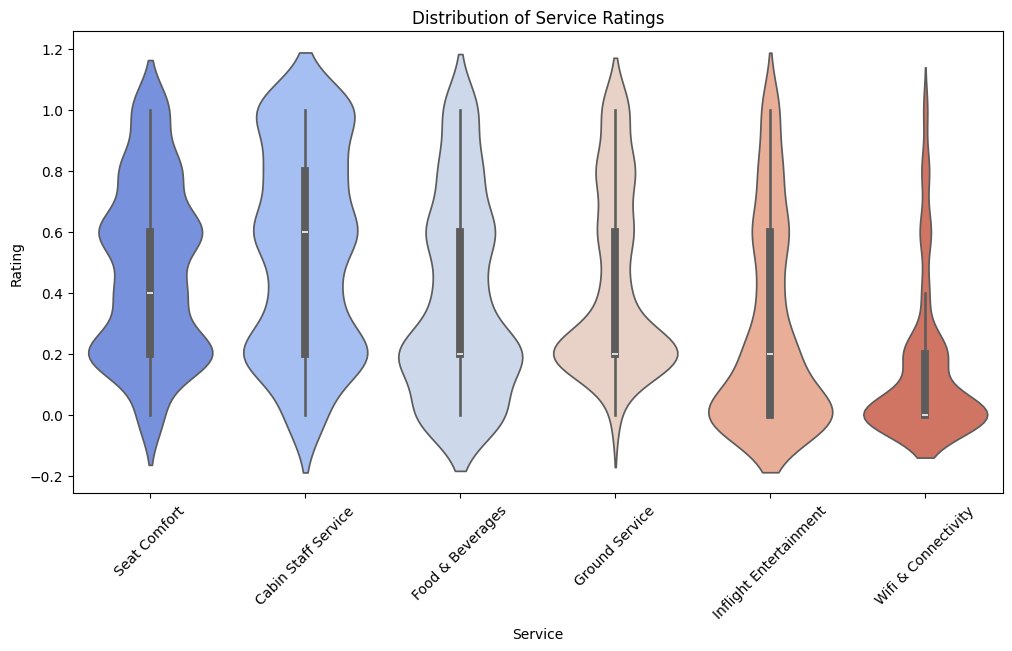

In [73]:
rating_columns = ["Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service", 
                  "Inflight Entertainment", "Wifi & Connectivity"]

df_melted = df.melt(value_vars=rating_columns, var_name="Service", value_name="Rating")

plt.figure(figsize=(12,6))
sns.violinplot(x="Service", y="Rating", data=df_melted, palette="coolwarm")
plt.title("Distribution of Service Ratings")
plt.xticks(rotation=45)
plt.show()


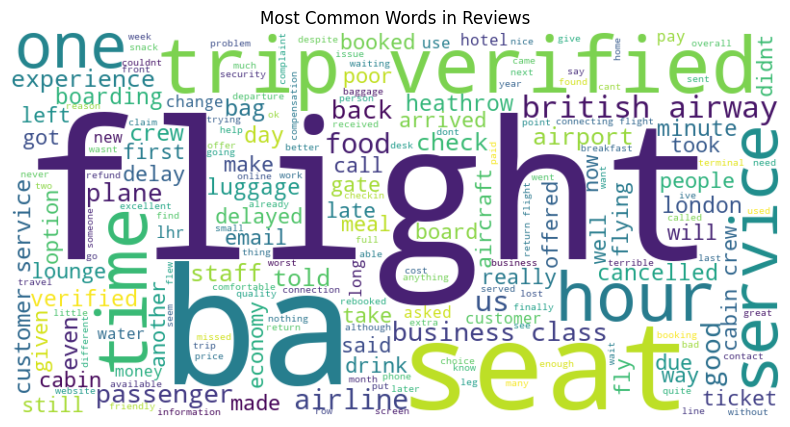

In [74]:
from wordcloud import WordCloud

all_reviews = " ".join(df["Review Text"])
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()


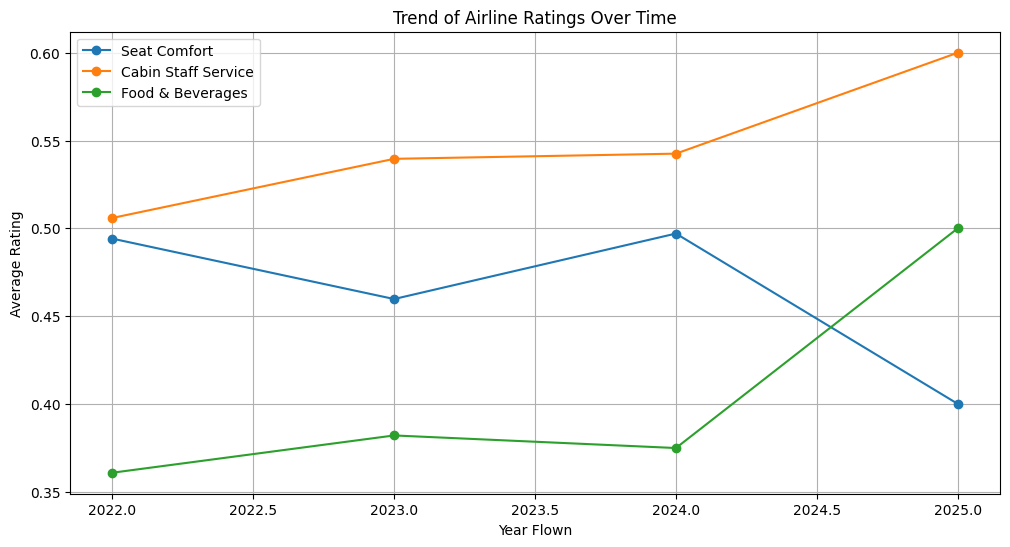

In [75]:
df["Year Flown"] = df["Date Flown"].dt.year

avg_ratings = df.groupby("Year Flown")[["Seat Comfort", "Cabin Staff Service", "Food & Beverages"]].mean()

plt.figure(figsize=(12,6))
for col in avg_ratings.columns:
    plt.plot(avg_ratings.index, avg_ratings[col], marker="o", label=col)

plt.title("Trend of Airline Ratings Over Time")
plt.xlabel("Year Flown")
plt.ylabel("Average Rating")
plt.legend()
plt.grid(True)
plt.show()


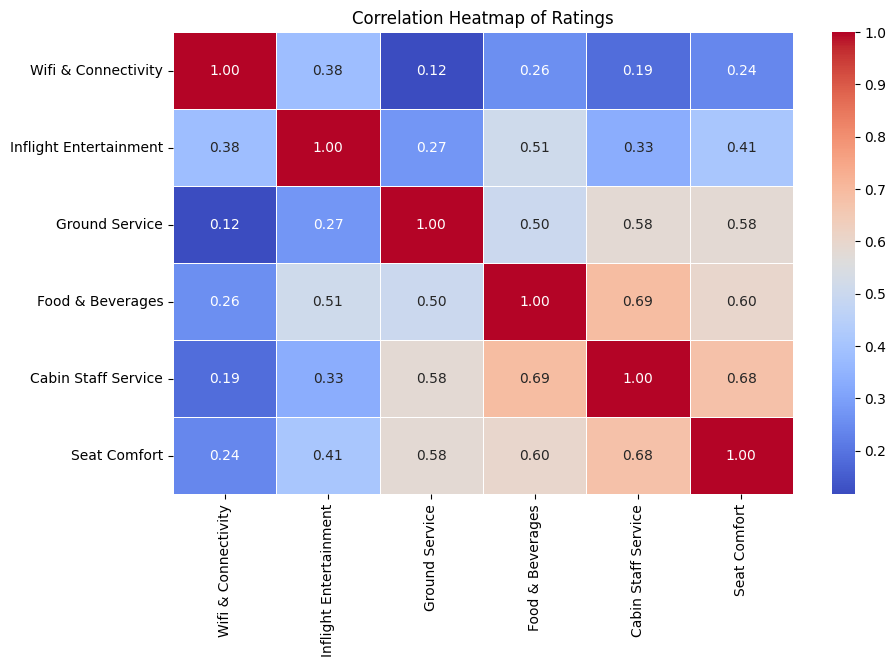

In [76]:
import numpy as np

plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Ratings")
plt.show()


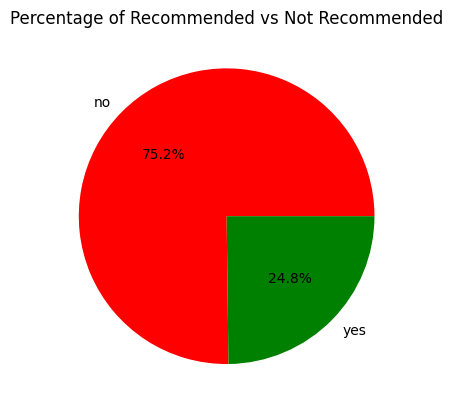

In [77]:
df["Recommended"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["red", "green"])
plt.title("Percentage of Recommended vs Not Recommended")
plt.ylabel("")  # Hide y-label
plt.show()


In [78]:
from sklearn.feature_extraction.text import CountVectorizer

# Filter negative reviews
negative_reviews = df[df["Sentiment"] < 0]["Review Text"]

# Vectorize words
vectorizer = CountVectorizer(stop_words="english", ngram_range=(1,2))
X = vectorizer.fit_transform(negative_reviews)

# Get word frequencies
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

# Sort words by frequency
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Display top 20 words
print(sorted_words[:20])


[('flight', 689), ('ba', 417), ('verified', 291), ('trip', 251), ('service', 229), ('trip verified', 212), ('british', 186), ('airways', 173), ('british airways', 168), ('hours', 165), ('time', 140), ('told', 139), ('customer', 136), ('seat', 134), ('class', 120), ('airline', 116), ('airport', 116), ('business', 114), ('heathrow', 114), ('did', 113)]


In [79]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Filter negative reviews only
negative_reviews = df[df["Sentiment"] < 0]["Review Text"]

# Define a list of stopwords (generic airline-related words)
custom_stopwords = ["flight", "ba", "verified", "trip", "british", "airways", 
                    "hours", "time", "told", "customer", "class", "airline", "airport", "business", "heathrow", "did"]

# Vectorize the text without generic words
vectorizer = CountVectorizer(stop_words=custom_stopwords, ngram_range=(1,2))
X = vectorizer.fit_transform(negative_reviews)

# Get word frequencies
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

# Sort words by frequency
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Display top 20 complaint-related words
print(sorted_words[:20])


[('the', 2436), ('to', 1939), ('and', 1442), ('was', 976), ('of', 707), ('in', 643), ('for', 571), ('we', 567), ('on', 556), ('that', 524), ('my', 511), ('not', 508), ('they', 474), ('with', 463), ('it', 384), ('at', 380), ('had', 371), ('no', 352), ('were', 348), ('is', 343)]


In [80]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text into numerical format using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(negative_reviews)

# Apply LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_tfidf)

# Display topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # Top 10 words per topic
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Topic 1: seat, business, hours, airways, british, verified, trip, service, ba, flight
Topic 2: little, disgusting, recline, clean, breakfast, ife, hot, legs, stand, space
Topic 3: good, recline, space, breakfast, seating, rome, hot, ife, legs, stand
